In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/data/processed/commit_info.csv')
print("Shape:", df.shape)
df.head()

Shape: (8796, 21)


,hash,msg,author,author_date,author_timezone,committer,committer_date,committer_timezone,in_main_branch,merge,...,num_lines_deleted,num_lines_added,num_lines_changed,num_files_changed,dmm_unit_size,dmm_unit_complexity,dmm_unit_interfacing,commit_type,cwe_id,repo_url
0,f1b6ebaa4ee049d966a9094428096b8f72cd492a,Coverity-CHECKED_RETURN,richard@hughsie.com,2016-09-19 10:03:36+01:00,-3600,richard@hughsie.com,2016-09-19 10:03:36+01:00,-3600,True,False,...,13,35,48,3,0.000000,0.0,0.000000,VCC,CWE-617,https://github.com/mdadams/jasper
1,df5d2867e8004e51e18b89865bc4aa69229227b3,CVE-2015-5221,richard@hughsie.com,2016-09-19 10:03:36+01:00,-3600,richard@hughsie.com,2016-09-19 10:03:36+01:00,-3600,True,False,...,1,1,2,1,NaN,NaN,NaN,FC,CWE-416,https://github.com/mdadams/jasper
2,3c55b399c36ef46befcb21e4ebc4799367f89684,"At many places in the code, jas_malloc or jas_...",mdadams@ece.uvic.ca,2016-10-15 10:42:19-07:00,25200,mdadams@ece.uvic.ca,2016-10-15 10:42:19-07:00,25200,True,False,...,117,173,290,25,0.967742,1.0,0.129032,VCC,CWE-122,https://github.com/mdadams/jasper
3,668e68295306a78a5e428df2ed80027c4eece964,Fix a potential double fclose of a FILE* in th...,mdadams@ece.uvic.ca,2016-10-18 08:11:07-07:00,25200,mdadams@ece.uvic.ca,2016-10-18 08:11:07-07:00,25200,True,False,...,0,6,6,2,0.500000,0.5,0.333333,VCC,CWE-190,https://github.com/mdadams/jasper
4,0c59a93f1b6433f259321939ee5f49eb45aa1e22,Added some extra debugging log messages for me...,mdadams@ece.uvic.ca,2016-10-19 15:29:20-07:00,25200,mdadams@ece.uvic.ca,2016-10-19 15:29:20-07:00,25200,True,False,...,1,4,5,1,1.000000,1.0,1.000000,VCC,CWE-190,https://github.com/mdadams/jasper


In [ ]:
df['author_date'] = pd.to_datetime(df['author_date'], errors='coerce', utc=True)
df['committer_date'] = pd.to_datetime(df['committer_date'], errors='coerce', utc=True)

df = df.dropna(subset=['msg','author_date','committer_date','author_timezone','committer_timezone'])
df["author_date_utc"]    = pd.to_datetime(df["author_date"],    errors="coerce", utc=True)
df["committer_date_utc"] = pd.to_datetime(df["committer_date"], errors="coerce", utc=True)
df["author_offset_s"]    = pd.to_numeric(df["author_timezone"],    errors="coerce").fillna(0).astype(int)
df["committer_offset_s"] = pd.to_numeric(df["committer_timezone"], errors="coerce").fillna(0).astype(int)

# Reconstruct local author time by *adding* the offset back
df["author_local_dt"]    = df["author_date_utc"]    - df["author_offset_s"].map(lambda s: pd.Timedelta(seconds=s))
df["committer_local_dt"] = df["committer_date_utc"] - df["committer_offset_s"].map(lambda s: pd.Timedelta(seconds=s))

df["author_hour_utc"]    = df["author_date_utc"].dt.hour
df["author_hour_local"]  = df["author_local_dt"].dt.hour
df["author_wday_utc"]    = df["author_date_utc"].dt.dayofweek
df["author_wday_local"]  = df["author_local_dt"].dt.dayofweek

df["committer_hour_utc"]   = df["committer_date_utc"].dt.hour
df["committer_hour_local"] = df["committer_local_dt"].dt.hour
df["committer_wday_utc"]   = df["committer_date_utc"].dt.dayofweek
df["committer_wday_local"] = df["committer_local_dt"].dt.dayofweek



In [4]:
df['churn'] = df['num_lines_added'] + df['num_lines_deleted']
df['log_churn'] = np.log1p(df['churn'])
df['churn'].describe(percentiles=[.5,.9,.99])
df['log_churn'].describe()


count    8690.000000
mean        4.583475
std         2.387332
min         0.693147
25%         2.708050
50%         4.317488
75%         6.061457
max        17.067264
Name: log_churn, dtype: float64

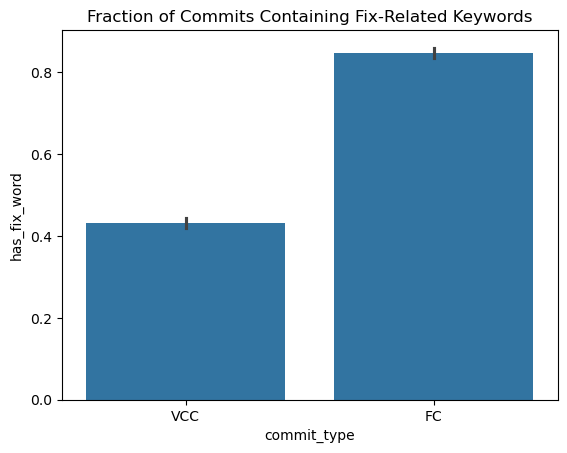

In [5]:
import re

part1 = r"(?:fix|fixed|fixes|patch|patched|patches|address|addresses|addressed|resolve|resolves|resolved|remediate|remediates|remediated|correct|corrects|corrected|mitigate|mitigates|mitigated|harden|hardens|hardened|secure|secures|secured|protect|protects|protected|guard|guards|guarded|enforce|enforces|enforced|restrict|restricts|restricted|sanitize|sanitizes|sanitized|validate|validates|validated|escape|escapes|escaped|encode|encodes|encoded|filter|filters|filtered|check|checks|checked|bound|bounds|bounded|clamp|clamps|clamped|initialize|initializes|initialized|null-?check|nullchecks|verify|verifies|verified|authenticate|authoriz(?:e|es|ed)|prevent|prevents|prevented|block|blocks|blocked|deny|denies|denied|reject|rejects|rejected|remove|removes|removed|disable|disables|disabled|revert|reverts|reverted|backport|backports|backported|bump|bumps|bumped)"
part2 = r"(?:bypass|bypasses|bypassed|skip|skips|skipped|ignore|ignores|ignored|relax|relaxes|relaxed|expose|exposes|exposed|leak|leaks|leaked|overflow|overflows|overflowed|underflow|underflows|underflowed|dereference|dereferences|dereferenced|trust|trusted|parse|parses|parsed)"
part3 = r"(?:security|vuln(?:erabilit(?:y|ies))?|cve|xss|csrf|sqli|rce|ssrf|lfi|rfi|dos|overflow|underflow|bug|error|issue|risk|fuck|bullshit|shit|deadline|sprint)"

pattern = r"\b" + part1 + r"\b|\b" + part2 + r"\b|\b" + part3 + r"\b"

df['has_fix_word'] = df['msg'].str.contains(pattern, flags=re.IGNORECASE, na=False).astype(int)
sns.barplot(x='commit_type', y='has_fix_word', data=df, estimator=np.mean)
plt.title("Fraction of Commits Containing Fix-Related Keywords")
plt.show()

In [6]:
df['has_fix_word'].mean()


np.float64(0.5680092059838895)

In [7]:
df[['committer_wday_local','committer_hour_local']].describe()

,committer_wday_local,committer_hour_local
count,8690.000000,8690.000000
mean,2.532336,13.792060
std,1.855507,5.590726
min,0.000000,0.000000
25%,1.000000,11.000000
50%,2.000000,14.000000
75%,4.000000,18.000000
max,6.000000,23.000000


In [8]:
df[['committer_wday_local','committer_hour_local']].head()


,committer_wday_local,committer_hour_local
0,0,10
1,0,10
2,5,10
3,1,8
4,2,15


In [9]:
df[['dmm_unit_size','dmm_unit_complexity']].isna().mean()


dmm_unit_size          0.161795
dmm_unit_complexity    0.161680
dtype: float64

In [10]:
for col in ['dmm_unit_size','dmm_unit_complexity']:
    df[col] = df[col].fillna(df[col].median())


In [11]:
df[['dmm_unit_size','dmm_unit_complexity']].describe()


,dmm_unit_size,dmm_unit_complexity
count,8690.000000,8690.000000
mean,0.239694,0.375428
std,0.359762,0.382323
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.034562,0.257114
75%,0.350000,0.735962
max,1.000000,1.000000


In [12]:
df['time_diff'] = (df['committer_local_dt'] - df['author_local_dt']).dt.total_seconds() / 3600  # in hours
df['time_diff'] = df['time_diff'].clip(lower=0, upper=df['time_diff'].quantile(0.99))
df['time_diff'].describe(percentiles=[.5,.9,.99])


count    8690.000000
mean      250.469275
std      1044.053415
min         0.000000
50%         0.000000
90%       313.739806
99%      7906.824687
max      7925.224475
Name: time_diff, dtype: float64

In [13]:
df['msg_len'] = df['msg'].astype(str).str.len()
df['msg_len'].describe(percentiles=[.5,.9,.99])

count      8690.000000
mean        338.294361
std        6815.967853
min           1.000000
50%         111.000000
90%         538.000000
99%        2145.990000
max      629086.000000
Name: msg_len, dtype: float64

In [14]:
df[['log_churn','has_fix_word','committer_wday_local','committer_hour_local',
    'dmm_unit_size','dmm_unit_complexity','time_diff','msg_len']].describe()


,log_churn,has_fix_word,committer_wday_local,committer_hour_local,dmm_unit_size,dmm_unit_complexity,time_diff,msg_len
count,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000
mean,4.583475,0.568009,2.532336,13.792060,0.239694,0.375428,250.469275,338.294361
std,2.387332,0.495382,1.855507,5.590726,0.359762,0.382323,1044.053415,6815.967853
min,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.708050,0.000000,1.000000,11.000000,0.000000,0.000000,0.000000,50.000000
50%,4.317488,1.000000,2.000000,14.000000,0.034562,0.257114,0.000000,111.000000
75%,6.061457,1.000000,4.000000,18.000000,0.350000,0.735962,4.318542,263.000000
max,17.067264,1.000000,6.000000,23.000000,1.000000,1.000000,7925.224475,629086.000000


In [15]:
# Weekday encoding
df['weekday_sin'] = np.sin(2 * np.pi * df['committer_wday_local'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['committer_wday_local'] / 7)

# Hour encoding
df['hour_sin'] = np.sin(2 * np.pi * df['committer_hour_local'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['committer_hour_local'] / 24)


In [16]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['log_churn', 'dmm_unit_size', 'dmm_unit_complexity',
                'time_diff', 'msg_len']

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df[numeric_cols] = df[numeric_cols].clip(-5, 5)


In [17]:
df['label'] = (df['commit_type'] == 'VCC').astype(int)
feature_cols = [
    'log_churn',
    'dmm_unit_size',
    'dmm_unit_complexity',
    'time_diff',
    'msg_len',
    'has_fix_word',
    'weekday_sin', 'weekday_cos',
    'hour_sin', 'hour_cos'
]
id_cols = ['hash', 'repo_url', 'author_date']


In [18]:
X = df[feature_cols]
y = df['label']


In [19]:
print(X.isna().sum())         # should be all 0
print(y.value_counts())       # class distribution
X.describe().T                # range check

log_churn              0
dmm_unit_size          0
dmm_unit_complexity    0
time_diff              0
msg_len                0
has_fix_word           0
weekday_sin            0
weekday_cos            0
hour_sin               0
hour_cos               0
dtype: int64
label
1    5832
0    2858
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
log_churn,8690.0,-2.640746e-05,0.999922,-1.629665,-0.785619,-0.111422,0.619129,5.000000
dmm_unit_size,8690.0,7.522432e-17,1.000058,-0.666296,-0.666296,-0.570220,0.306626,2.113482
dmm_unit_complexity,8690.0,-1.962373e-17,1.000058,-0.982020,-0.982020,-0.309478,0.943064,1.633718
time_diff,8690.0,-2.595973e-02,0.824988,-0.239915,-0.239915,-0.239915,-0.235778,5.000000
msg_len,8690.0,-1.036056e-02,0.139114,-0.049489,-0.042299,-0.033349,-0.011047,5.000000
has_fix_word,8690.0,5.680092e-01,0.495382,0.000000,0.000000,1.000000,1.000000,1.000000
weekday_sin,8690.0,1.670226e-01,0.657870,-0.974928,-0.433884,0.433884,0.781831,0.974928
weekday_cos,8690.0,-5.857293e-03,0.734430,-0.900969,-0.900969,-0.222521,0.623490,1.000000
hour_sin,8690.0,-2.588953e-01,0.619139,-1.000000,-0.866025,-0.500000,0.258819,1.000000
hour_cos,8690.0,-2.583057e-01,0.694995,-1.000000,-0.866025,-0.500000,0.500000,1.000000


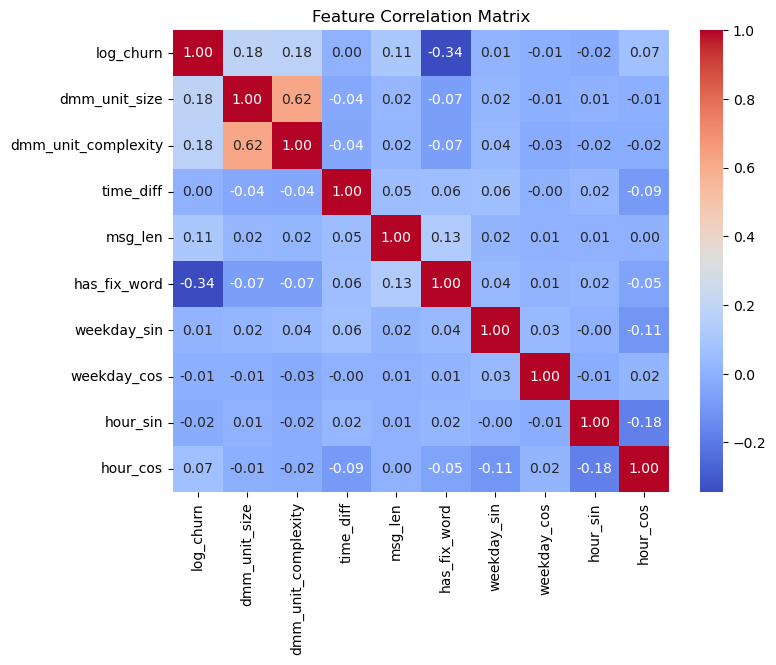

In [21]:
corr = X.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
# Combine everything into one final dataframe
final_df = df[id_cols + feature_cols + ['label']]

# Save as CSV
output_path = "../data/data/processed/icvul_features_final.csv"
final_df.to_csv(output_path, index=False)

print(f"File saved successfully at: {output_path}")
print(f"Shape: {final_df.shape}")


✅ File saved successfully at: ../data/data/processed/icvul_features_final.csv
Shape: (8690, 14)
